In [1]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from copy import copy

In [2]:
from Games import *
import Utility
from os import listdir, mkdir
from os.path import join, isdir
from json import load
from glob import glob

In [3]:
FIGURE = 'figure'
if not isdir(FIGURE):
    mkdir(FIGURE)

In [4]:
PALETTE = {
    "PI": "red", 
    "API": "blue", 
    "Random": "orange", 
    "Greedy": "green",
}

In [5]:
def heatmap(dataframe, graph, bounds, player_name, reward_type, info):
    # heat map is only built for both reward
    max_x, max_y = bounds
    max_val = 0
    heatmap_data = {}
    
    if player_name == None:
        p_df = dataframe[dataframe['Reward Type'] == reward_type]
    else:
        p_df = dataframe[dataframe['Agent'] == player_name]
        p_df = p_df[p_df['Reward Type'] == reward_type]
    
    # This block of code finds the number of elites per grid cell. We
    # use this to average the heatmap
    counter = {}
    for node in graph.nodes:
        if '__' in node or node == 'start_node' or node == 'death_node':
            continue
        
        a,b,_ = node.split(',')
        key = (int(b), int(a))
        if key in counter:
            counter[key] += 1
        else:
            counter[key] = 1
    
    # build entry in heatmap data 
    for name, d_df in p_df.groupby('Director'):
        data = np.zeros((max_y+1, max_x+1))
        mask = np.ones((max_y+1, max_x+1))
        
        # build the mask
        for n in graph.nodes:
            if '__' in n or n == 'start_node' or n == 'death_node':
                continue

            a,b,_ = n.split(',')
            mask[int(b)][int(a)] = 0.0
            
        # build heatmap occurrences for each node
        for i, row in d_df.iterrows():
            for n in row.Nodes:
                if '__' in n:
                    continue

                a, b, _ = n.split(',')
                data[int(b)][int(a)] += 1.0
                
        # average the heatmap for the number of runs and cells
        for (y,x), count in counter.items():
            data[y][x] /= info['runs']*count
            max_val = max(data[y][x], max_val) 
        
        # store heatmap data
        heatmap_data[name] = (data, mask)
    
    fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(20,4))
    cbar_ax = fig.add_axes([.92, .1, .02, .77])
    
    ordered_directors = list(heatmap_data.keys())
    ordered_directors.sort()
    
    cmap = copy(plt.get_cmap('vlag'))
    cmap.set_under('gray')

    for i, director in enumerate(ordered_directors):
        data, mask = heatmap_data[director]
        ax = sns.heatmap(
            data, 
            mask=mask,
            square=True,
            cmap=cmap,
            ax=axes[i],
            cbar_ax=cbar_ax if i == 3 else None,
            cbar=i==3,
            vmin=0.01,
            vmax=max_val
        )
        
        axes[i].invert_yaxis()
#         axes[i].set_title(f'{director}', y=-0.1)
        axes[i].set_title(director)
        axes[i].set_facecolor("black")
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_aspect('auto')
        
        if i == 0:
            axes[i].set_ylabel('Leniency', fontsize=14)
    
    if player_name ==None:
        fig.suptitle(f'Switching Players Graph', fontsize=16, y=0.99)
        
    else:
        if 'Likes High A' in player_name:
            player_name = player_name.replace('High A', 'High Density')
        elif 'Likes High B' in player_name:
            player_name = player_name.replace('High B', 'High Leniency')
        
        fig.suptitle(f'{player_name} for {reward_type} Reward', fontsize=16, y=0.99)
    fig.text(0.5, 0.02, 'Density', ha='center', size=14)
#     plt.show()
    plt.savefig(f'figure/segment_heatmap_{player_name}_{reward_type}.pdf') 

In [6]:
def heatmap_no_greedy(dataframe, graph, bounds, player_name, reward_type, info):
    # heat map is only built for both reward
    max_x, max_y = bounds
    max_val = 0
    heatmap_data = {}
    
    if player_name == None:
        p_df = dataframe[dataframe['Reward Type'] == reward_type]
    else:
        p_df = dataframe[dataframe['Agent'] == player_name]
        p_df = p_df[p_df['Reward Type'] == reward_type]
    
    # This block of code finds the number of elites per grid cell. We
    # use this to average the heatmap
    counter = {}
    for node in graph.nodes:
        if '__' in node:
            continue

        a,b,_ = node.split('_')
        key = (int(b), int(a))
        if key in counter:
            counter[key] += 1
        else:
            counter[key] = 1
    
    # build entry in heatmap data 
    for name, d_df in p_df.groupby('Director'):
        if name == 'Greedy':
            continue
            
        data = np.zeros((max_y+1, max_x+1))
        mask = np.ones((max_y+1, max_x+1))
        
        # build the mask
        for n in graph.nodes:
            if '__' in n:
                continue

            a,b,_ = n.split(',')
            mask[int(b)][int(a)] = 0.0
            
        # build heatmap occurrences for each node
        for i, row in d_df.iterrows():
            for n in row.Nodes:
                if '__' in n:
                    continue

                a, b, _ = n.split(',')
                data[int(b)][int(a)] += 1.0
                
        # average the heatmap for the number of runs and cells
        for (y,x), count in counter.items():
            data[y][x] /= info['runs']*count
            max_val = max(data[y][x], max_val) 
        
        # store heatmap data
        heatmap_data[name] = (data, mask)
    
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(20,4))
    cbar_ax = fig.add_axes([.92, .1, .02, .77])
    
    ordered_directors = list(heatmap_data.keys())
    ordered_directors.sort()
    
    cmap = copy(plt.get_cmap('Greens_r'))
    cmap.set_under('gray')

    for i, director in enumerate(ordered_directors):
        data, mask = heatmap_data[director]
        ax = sns.heatmap(
            data, 
            mask=mask,
            square=True,
            cmap=cmap,
            ax=axes[i],
            cbar_ax=None if i != 2 else cbar_ax,
            cbar=i==2,
            vmin=0.01,
            vmax=max_val
        )
        
        axes[i].invert_yaxis()
#         axes[i].set_title(f'{director}', y=-0.1)
        axes[i].set_title(director)
        axes[i].set_facecolor("black")
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_aspect('auto')
        
        if i == 0:
            axes[i].set_ylabel('Leniency', fontsize=14)
    
    if player_name ==None:
        fig.suptitle(f'Switching Players Graph', fontsize=16, y=0.99)
        
    else:
        if 'Likes High A' in player_name:
            player_name = player_name.replace('High A', 'High Density')
        elif 'Likes High B' in player_name:
            player_name = player_name.replace('High B', 'High Leniency')
        
        fig.suptitle(f'{player_name} for {reward_type} Reward', fontsize=16, y=0.99)
    fig.text(0.5, 0.02, 'Density', ha='center', size=14)
#     plt.show()
    plt.savefig(f'figure/segment_heatmap_no_greedy_{player_name}_{reward_type}.pdf') 

In [7]:
def switch_heatmap(dataframe, graph, bounds, player_name, reward_type, info):
    # heat map is only built for both reward
    max_x, max_y = bounds
    max_val = 0
    heatmap_data = {}
    
    if player_name == None:
        p_df = dataframe[dataframe['Reward Type'] == reward_type]
    else:
        p_df = dataframe[dataframe['Agent'] == player_name]
        p_df = p_df[p_df['Reward Type'] == reward_type]
    
    # This block of code finds the number of elites per grid cell. We
    # use this to average the heatmap
    counter = {}
    for node in graph.nodes:
        if '__' in node or node == 'start_node' or node == 'death_node':
            continue

        a,b,_ = node.split(',')
        key = (int(b), int(a))
        if key in counter:
            counter[key] += 1
        else:
            counter[key] = 1
    
    # build entry in heatmap data 
    for name, d_df in p_df.groupby('Director'):
        min_level = 0
        heatmap_data[name] = [None, None]
        for index, percentage in enumerate([0.7, 0.3]):
            data = np.zeros((max_y+1, max_x+1))
            mask = np.ones((max_y+1, max_x+1))
            
            # filter for the correct split in levels
            old_min_level = min_level
            min_level += int((df.Level.max()+1)*percentage)
            r_df = d_df[d_df.Level.between(old_min_level-1, min_level)]
            
            # build the mask
            for n in graph.nodes:
                if '__' in n or n == 'start_node' or n == 'death_node':
                    continue
        
                a,b,_ = n.split(',')
                mask[int(b)][int(a)] = 0.0

            # build heatmap occurrences for each node
            for i, row in r_df.iterrows():
                for n in row.Nodes:
                    if '__' in n:
                        continue

                    a, b, _ = n.split(',')
                    data[int(b)][int(a)] += 1.0

            # average the heatmap for the number of runs and cells
            for (y,x), count in counter.items():
                data[y][x] /= info['runs']*count
                max_val = max(data[y][x], max_val) 

            # store heatmap data
            heatmap_data[name][index] = (data, mask)
    
    fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(20,8))
    cbar_ax = fig.add_axes([.92, .1, .02, .77])
    
    ordered_directors = list(heatmap_data.keys())
    ordered_directors.sort()
    
    cmap = copy(plt.get_cmap('vlag'))
    cmap.set_under('gray')

    for i, director in enumerate(ordered_directors):
        for j in range(2):
            data, mask = heatmap_data[director][j]
            ax = sns.heatmap(
                data, 
                mask=mask,
                square=True,
                cmap=cmap,
                ax=axes[j,i],
                cbar_ax=None if i != 3 else cbar_ax,
                cbar=i==3,
                vmin=0.01,
                vmax=max_val
            )

            axes[j,i].invert_yaxis()
    #         axes[i].set_title(f'{director}', y=-0.1)
            axes[j,i].set_title(director)
            axes[j,i].set_facecolor("black")
            axes[j,i].set_xticks([])
            axes[j,i].set_yticks([])
            axes[j,i].set_aspect('auto')

            if i == 0:
                axes[j,i].set_ylabel('Leniency', fontsize=14)
    
    if player_name ==None:
        fig.suptitle(f'Switching From Good Player to Bad Player with {reward_type} Reward', fontsize=16, y=0.99)
    else:
        if 'Likes High A' in player_name:
            player_name = player_name.replace('High A', 'High Density')
        elif 'Likes High B' in player_name:
            player_name = player_name.replace('High B', 'High Leniency')
        
        fig.suptitle(f'{player_name} for {reward_type} Reward', fontsize=16, y=0.99)
        
    def convert(name):
        if 'Likes High A' in name:
            return name.replace('High A', 'High Density')
        elif 'Likes High B' in name:
            return name.replace('High B', 'High Leniency')
        return name
        
    fig.text(0.5, 0.02, 'Density', ha='center', size=14)
    fig.text(0.099, 0.55, convert(info['players'][0]), rotation=90, ha='center', size=14)
    fig.text(0.099, 0.11, convert(info['players'][1]), rotation=90, ha='center', size=14)
#     plt.show()
    plt.savefig('figure/switch_heatmap.pdf')     

In [8]:
def get_all_player_playthroughs(config, start):
    d = []
    info = None
    
    for path in glob(join(config.BASE_DIR, f'{start}*reward_*.json')):
        path_split = path.split('/')[-1].split('_')
        player = path_split[1]
        director = path_split[-3]
        if director == 'Adaptive Policy':
            director = 'API'
        elif director == 'Policy':
            director = 'PI'
        
        reward = path_split[-1].split('.')[0]
        
        with open(path, 'r') as f:
            temp = load(f)
            data = temp['data']
            info = temp['info']
        
        for i_session, session in enumerate(data):
            for i_run, run in enumerate(session):
                nodes = []
                sum_percent_complete = 0
                sum_percent_design = 0
                sum_percent_player = 0
                sum_percent_total = 0
                
                for entry in run['Playthrough']:
                    nodes.append(entry['node_name'])
                    
                    sum_percent_complete += entry['Percent Completable']
                    sum_percent_design += entry['Designer Reward']
                    sum_percent_player += entry['Agent Reward']
                    sum_percent_total += entry['Total Reward']
                    
#                 d.append((
#                     reward, 
#                     player, 
#                     director,
#                     i_run,
#                     sum_percent_complete,
#                     sum_percent_design,
#                     sum_percent_player,
#                     sum_percent_total,
#                     nodes
#                 ))
                    
                d.append((
                    reward, 
                    player, 
                    director,
                    i_run,
                    run['percent_complete'],
                    run['percent_design_reward'],
                    run['percent_player_reward'],
                    run['percent_total_reward'],
                    run['percent_reward'],
                    nodes
                ))
    
    labels = (
        'Reward Type', 
        'Agent', 
        'Director',
        'Level',
        'Percent Complete', 
        'Design Reward', 
        'Player Reward', 
        'Total Reward',
        'Reward',
        'Nodes'
    )
    return pd.DataFrame(d, columns=labels), info

In [9]:
def plot_player_personas_over_time(df):
    # sort keys so the output is always in the same order
    player_names = list(df.Agent.unique())
    player_names.sort()
    
    reward_names = ['BOTH', 'Percent Complete']
#     reward_names = ['DESIGNER', 'PLAYER', 'BOTH', 'Percent Complete']
    
    # build plots and set title
    fig, axes = plt.subplots(len(reward_names), len(player_names), sharex=True, sharey=True, figsize=(20,8))
    fig.suptitle(f'Average Reward Per Level for Icarus', fontsize=16)
    
    # fill in each plot
    for y, name in enumerate(reward_names):
        for x, player in enumerate(player_names):
            if name == 'Percent Complete':
                g_df = df[df['Reward Type'] == 'BOTH']
            else:
                g_df = df[df['Reward Type'] == name]
                
            g_df = g_df[g_df['Agent'] == player]
            
            if name == 'Percent Complete':
#                 ax = sns.lineplot(ax=axes[y, x], data=g_df, x='Level', y='Percent Complete', hue='Director', palette=PALETTE)
                ax = sns.lineplot(ax=axes[y,x], data=g_df, x='Level', y='Percent Complete', hue='Director', palette=PALETTE)
            else:
#                 ax = sns.lineplot(ax=axes[y, x], data=g_df, x='Level', y='Reward', hue='Director', palette=PALETTE)
                ax = sns.lineplot(ax=axes[y,x], data=g_df, x='Level', y='Reward', hue='Director', palette=PALETTE)
            ax.get_legend().remove()
            ax.set_xlabel('')
            ax.set_ylabel(REWARD_MAP[name])
            
            if y == 0:
                if 'Likes High A' in player:
                    player = player.replace('High A', 'High Density')
                elif 'Likes High B' in player:
                    player = player.replace('High B', 'High Leniency')
                    
                ax.set_title('Likes\n'.join(player.split('Likes')), fontsize=12)
                
            if x == 0:
                ax.set_ylabel(name, fontsize=14)
            else:
                ax.set_ylabel('')
                
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', ncol=2, bbox_to_anchor=(.905, 0.99))
    fig.text(0.5, 0.08, 'Level', ha='center', size=14)
#     fig.text(0.08, 0.5, 'Reward', va='center', rotation='vertical', size=14)
#     plt.show()
    plt.savefig('figure/icarus_segments_graph.pdf')     

In [10]:
# REWARD_MAP = {
#     'DESIGNER': 'Design Reward',
#     'PLAYER': 'Player Reward',
#     'BOTH': 'Total Reward',
#     'Percent Complete': 'Percent Complete',
# }

REWARD_MAP = {
    'DESIGNER': 'Design Reward',
    'PLAYER': 'Player Reward',
    'BOTH': 'Reward',
    'Percent Complete': 'Percent Complete',
}

# Icarus Level Segments

In [11]:
config = ICARUS
graph = Utility.get_level_segment_graph(config, True)


REWARD_STR = Utility.reward_type_to_str(Utility.RewardType.DESIGNER)
df, info = get_all_player_playthroughs(config, 'player')

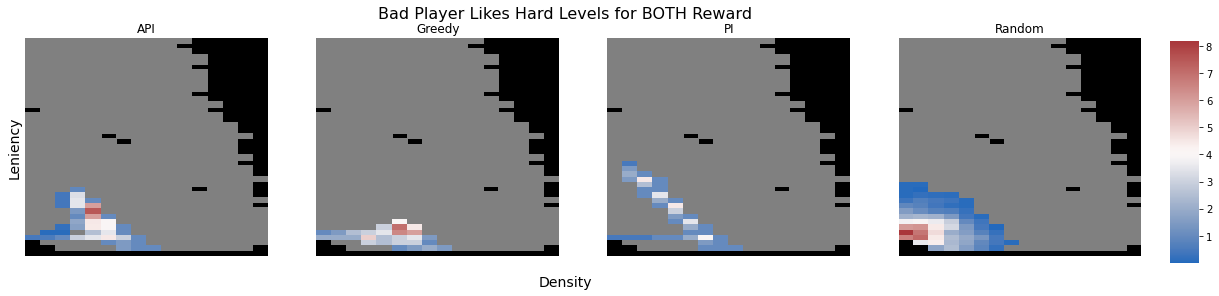

In [12]:
heatmap(df, graph, config.MAX_BC, 'Bad Player Likes Hard Levels', 'BOTH', info) 

In [13]:
bplhl = df[df['Agent'] == 'Bad Player Likes Hard Levels']
bplhl.groupby(['Director']).mean('Reward')['Reward']

Director
API       0.169832
Greedy    0.117803
PI        0.152224
Random    0.120811
Name: Reward, dtype: float64

In [14]:
bplhl.groupby(['Director']).std()['Reward']

Director
API       0.076680
Greedy    0.073864
PI        0.091189
Random    0.081435
Name: Reward, dtype: float64

In [15]:
bplhl.groupby(['Director']).mean('Percent Complete')['Percent Complete']

Director
API       0.655462
Greedy    0.559416
PI        0.404640
Random    0.988413
Name: Percent Complete, dtype: float64

In [16]:
bplhl.groupby(['Director']).std()['Percent Complete']

Director
API       0.298608
Greedy    0.336820
PI        0.276983
Random    0.080761
Name: Percent Complete, dtype: float64

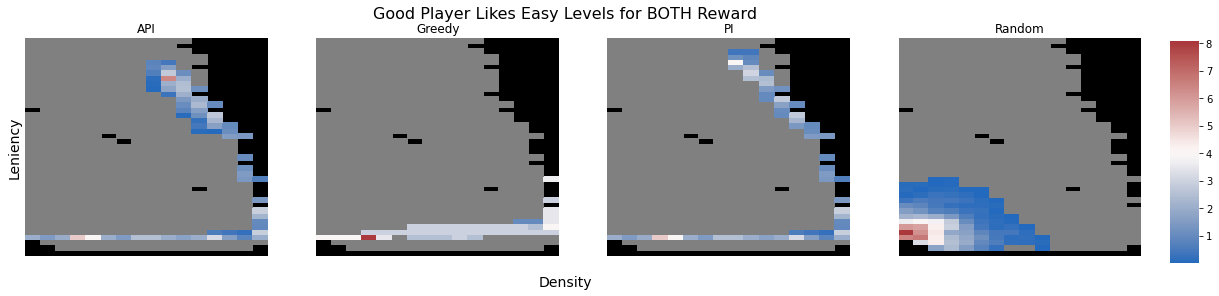

In [17]:
heatmap(df, graph, config.MAX_BC, 'Good Player Likes Easy Levels', 'BOTH', info) 

In [18]:
gplel = df[df['Agent'] == 'Good Player Likes Easy Levels']
gplel.groupby(['Director']).mean('Reward')['Reward']

Director
API       0.507934
Greedy    0.496477
PI        0.482619
Random    0.500918
Name: Reward, dtype: float64

In [19]:
gplel.groupby(['Director']).std()['Reward']

Director
API       0.248563
Greedy    0.221597
PI        0.251858
Random    0.214334
Name: Reward, dtype: float64

In [20]:
gplel.groupby(['Director']).mean('Percent Complete')['Percent Complete']

Director
API       0.844190
Greedy    1.000000
PI        0.788969
Random    1.000000
Name: Percent Complete, dtype: float64

In [21]:
gplel.groupby(['Director']).std()['Percent Complete']

Director
API       0.268321
Greedy    0.000000
PI        0.304249
Random    0.000000
Name: Percent Complete, dtype: float64

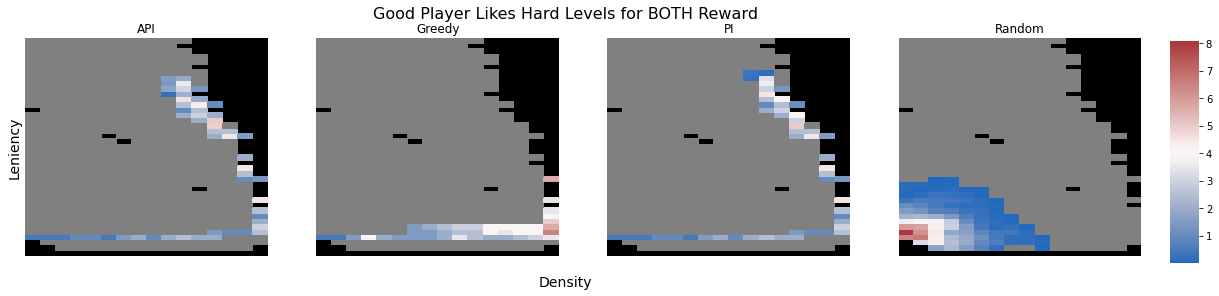

In [22]:
heatmap(df, graph, config.MAX_BC, 'Good Player Likes Hard Levels', 'BOTH', info) 

In [23]:
gplhl = df[df['Agent'] == 'Good Player Likes Hard Levels']
gplhl.groupby(['Director']).mean('Reward')['Reward']

Director
API       0.609248
Greedy    0.451944
PI        0.575119
Random    0.132343
Name: Reward, dtype: float64

In [24]:
gplhl.groupby(['Director']).std()['Reward']

Director
API       0.314993
Greedy    0.200562
PI        0.307020
Random    0.097225
Name: Reward, dtype: float64

In [25]:
gplhl.groupby(['Director']).mean('Percent Complete')['Percent Complete']

Director
API       0.921667
Greedy    1.000000
PI        0.863921
Random    1.000000
Name: Percent Complete, dtype: float64

In [26]:
gplhl.groupby(['Director']).std()['Percent Complete']

Director
API       0.205281
Greedy    0.000000
PI        0.271562
Random    0.000000
Name: Percent Complete, dtype: float64

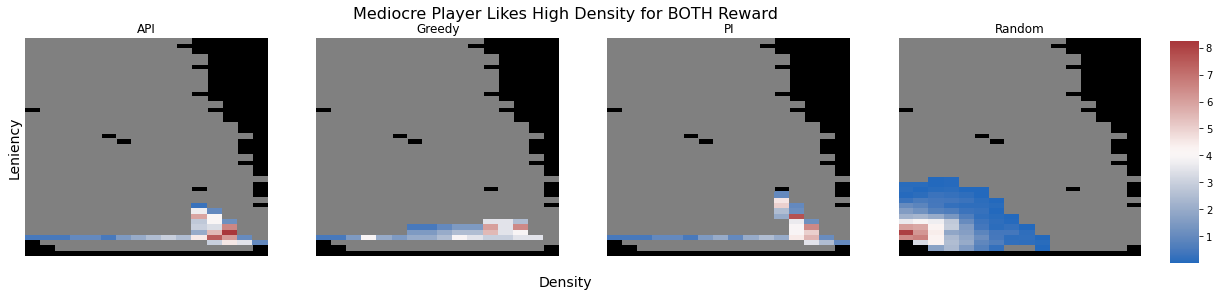

In [27]:
heatmap(df, graph, config.MAX_BC, 'Mediocre Player Likes High A', 'BOTH', info) 

In [28]:
mplha = df[df['Agent'] == 'Mediocre Player Likes High A']
mplha.groupby(['Director']).mean('Reward')['Reward']

Director
API       0.442683
Greedy    0.397401
PI        0.418682
Random    0.137465
Name: Reward, dtype: float64

In [29]:
mplha.groupby(['Director']).std()['Reward']

Director
API       0.231992
Greedy    0.213965
PI        0.218335
Random    0.120534
Name: Reward, dtype: float64

In [30]:
mplha.groupby(['Director']).mean('Percent Complete')['Percent Complete']

Director
API       0.768397
Greedy    0.684667
PI        0.627799
Random    1.000000
Name: Percent Complete, dtype: float64

In [31]:
mplha.groupby(['Director']).std()['Percent Complete']

Director
API       0.296423
Greedy    0.302750
PI        0.338915
Random    0.000000
Name: Percent Complete, dtype: float64

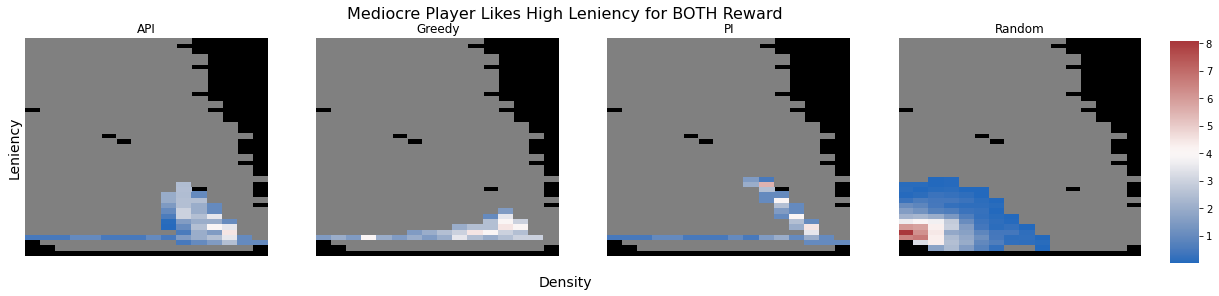

In [32]:
heatmap(df, graph, config.MAX_BC, 'Mediocre Player Likes High B', 'BOTH', info) 

In [33]:
mplhb = df[df['Agent'] == 'Mediocre Player Likes High B']
mplhb.groupby(['Director']).mean('Reward')['Reward']

Director
API       0.283514
Greedy    0.194952
PI        0.211951
Random    0.127220
Name: Reward, dtype: float64

In [34]:
mplhb.groupby(['Director']).std()['Reward']

Director
API       0.136552
Greedy    0.101447
PI        0.142195
Random    0.085765
Name: Reward, dtype: float64

In [35]:
mplhb.groupby(['Director']).mean('Percent Complete')['Percent Complete']

Director
API       0.708853
Greedy    0.660905
PI        0.449375
Random    1.000000
Name: Percent Complete, dtype: float64

In [36]:
mplhb.groupby(['Director']).std()['Percent Complete']

Director
API       0.288605
Greedy    0.322923
PI        0.313076
Random    0.000000
Name: Percent Complete, dtype: float64

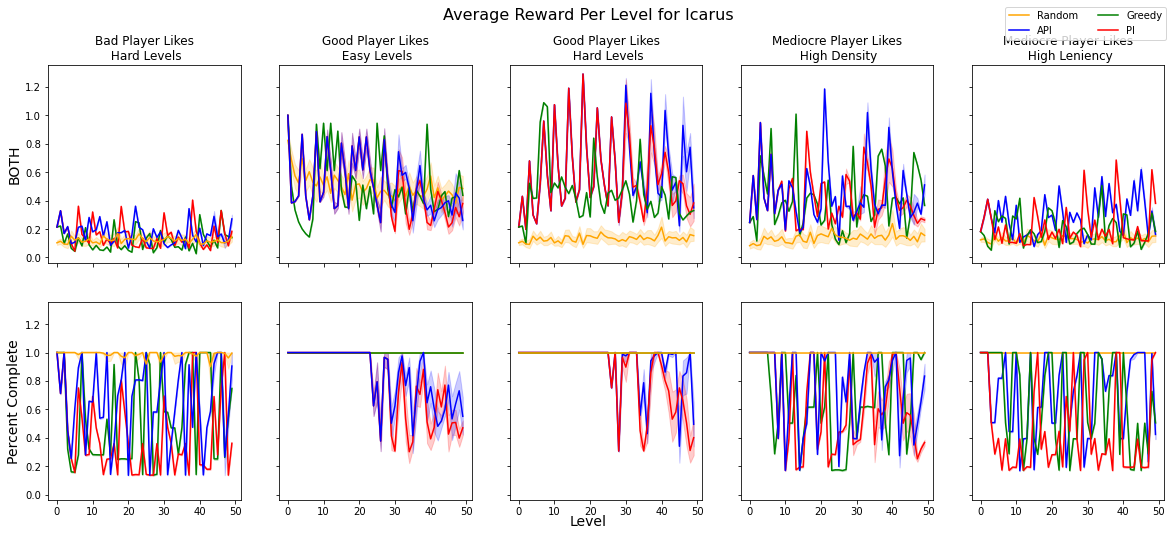

In [37]:
plot_player_personas_over_time(df)

In [38]:
df[df['Reward Type'] == 'BOTH'].groupby(['Director']).mean('Reward')['Reward']

Director
API       0.402642
Greedy    0.331715
PI        0.368119
Random    0.203751
Name: Reward, dtype: float64

In [39]:
df[df['Reward Type'] == 'BOTH'].groupby(['Director']).std()['Reward']

Director
API       0.269426
Greedy    0.228534
PI        0.269538
Random    0.197180
Name: Reward, dtype: float64

In [40]:
df[df['Reward Type'] == 'BOTH'].groupby(['Director']).mean('Percent Complete')['Percent Complete']

Director
API       0.779714
Greedy    0.780998
PI        0.626941
Random    0.997683
Name: Percent Complete, dtype: float64

In [41]:
df[df['Reward Type'] == 'BOTH'].groupby(['Director']).std()['Percent Complete']

Director
API       0.289506
Greedy    0.309159
PI        0.351836
Random    0.036399
Name: Percent Complete, dtype: float64

# Switching Players

In [42]:
config = ICARUS
graph = Utility.get_level_segment_graph(config, True)

rewards = ('Design Reward', 'Player Reward', 'Both Reward')

REWARD_STR = Utility.reward_type_to_str(Utility.RewardType.BOTH)
df, info = get_all_player_playthroughs(config, 'switch')

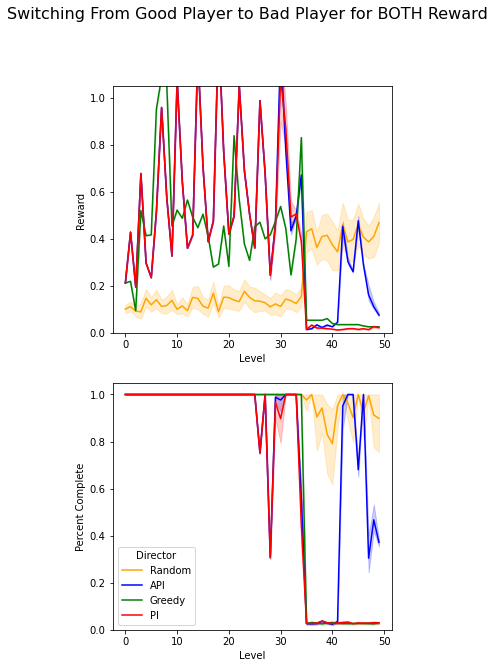

In [43]:
fig, axes = plt.subplots(2, 1, figsize=(5,10))

fig.suptitle(f'Switching From Good Player to Bad Player for BOTH Reward', fontsize=16, y=0.99)
ax = sns.lineplot(ax=axes[0], data=df, x='Level', y='Reward', hue='Director', palette=PALETTE)
ax.set(ylim=(0, 1.05))
axes[0].set_ylabel('Reward')
axes[0].get_legend().remove()

ax = sns.lineplot(ax=axes[1], data=df, x='Level', y='Percent Complete', hue='Director', palette=PALETTE)
ax.set(ylim=(0, 1.05))

plt.savefig('figure/switching_players_reward.pdf', bbox_inches='tight')  

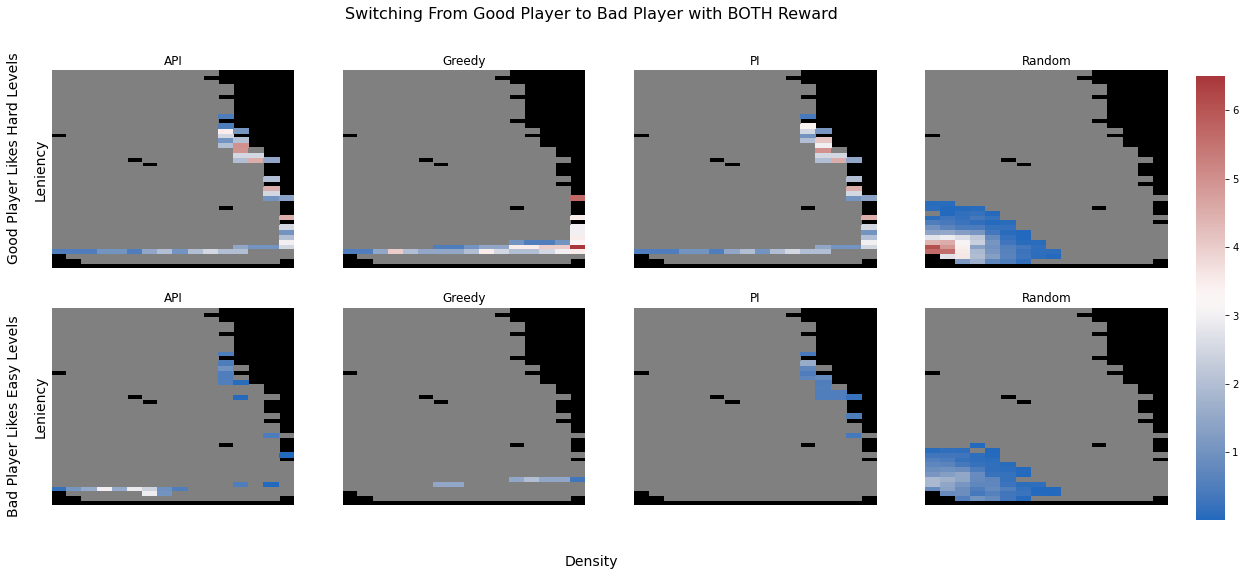

In [44]:
switch_heatmap(df, graph, config.MAX_BC, None, 'BOTH', info)

Good Player Likes Hard Levels

In [45]:
temp_df = df[df['Level'] <= 35]
temp_df[temp_df['Reward Type'] == 'BOTH'].groupby(['Director']).mean('Reward')['Reward']

Director
API       0.591225
Greedy    0.473228
PI        0.584117
Random    0.137509
Name: Reward, dtype: float64

In [46]:
temp_df[temp_df['Reward Type'] == 'BOTH'].groupby(['Director']).std()['Reward']

Director
API       0.312169
Greedy    0.230483
PI        0.316601
Random    0.108217
Name: Reward, dtype: float64

Bad Player Likes Easy Levels

In [47]:
temp_df = df[df['Level'] > 35]
temp_df[temp_df['Reward Type'] == 'BOTH'].groupby(['Director']).mean('Reward')['Reward']

Director
API       0.166807
Greedy    0.040757
PI        0.020786
Random    0.410698
Name: Reward, dtype: float64

In [48]:
temp_df[temp_df['Reward Type'] == 'BOTH'].groupby(['Director']).std()['Reward']

Director
API       0.161882
Greedy    0.011345
PI        0.007835
Random    0.202355
Name: Reward, dtype: float64

All

In [49]:
df[df['Reward Type'] == 'BOTH'].groupby(['Director']).mean('Reward')['Reward']

Director
API       0.472388
Greedy    0.352137
PI        0.426384
Random    0.214002
Name: Reward, dtype: float64

In [50]:
df[df['Reward Type'] == 'BOTH'].groupby(['Director']).std()['Reward']

Director
API       0.337351
Greedy    0.275704
PI        0.369052
Random    0.186883
Name: Reward, dtype: float64

# N-Gram

In [51]:
config = MARIO
graph = Utility.get_level_segment_graph(config, True)

rewards = ('Design Reward', 'Player Reward', 'Both Reward')

REWARD_STR = Utility.reward_type_to_str(Utility.RewardType.DESIGNER)
df, info = get_all_player_playthroughs(config, 'player')

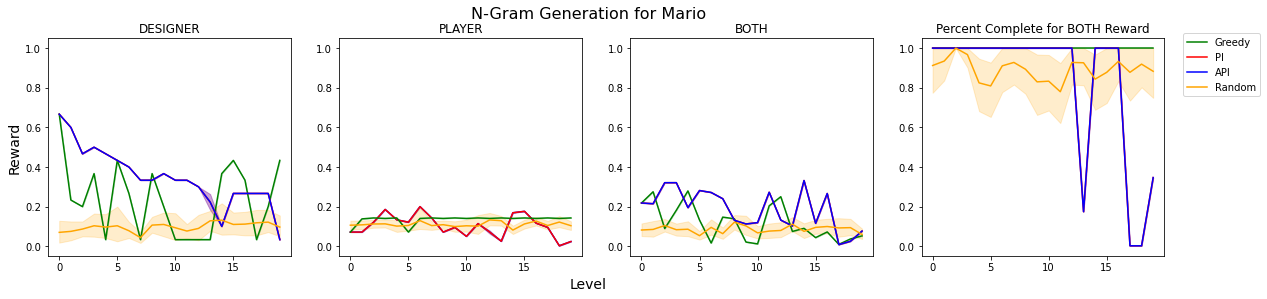

In [52]:
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(20,4))
    
for i, rt in enumerate(['DESIGNER', 'PLAYER', 'BOTH']):
    g_df = df[df['Reward Type'] == rt]
    ax = sns.lineplot(ax=axes[i], data=g_df, x='Level', y=REWARD_MAP[rt], hue='Director', palette=PALETTE)
    axes[i].set_title(rt)
    axes[i].set_ylabel('Reward',fontsize=14)
    axes[i].set_xlabel('')
    axes[i].get_legend().remove()
#     axes[i].tick_params(axis='both', which='both')
    axes[i].yaxis.set_tick_params(labelbottom=True)
    
    
g_df = df[df['Reward Type'] == 'BOTH']
ax = sns.lineplot(ax=axes[3], data=g_df, x='Level', y='Percent Complete', hue='Director', palette=PALETTE)
axes[3].set_title('Percent Complete for BOTH Reward')
axes[3].set_ylabel('Percent Complete',fontsize=14)
axes[3].set_xlabel('')
axes[3].get_legend().remove()
axes[3].yaxis.set_tick_params(labelbottom=True)

    
handles, labels = axes[0].get_legend_handles_labels()   
fig.legend(handles, labels, loc='upper right', ncol=1, bbox_to_anchor=(.97, 0.915))
fig.text(0.5, 0.01, 'Level', ha='center', size=14)
fig.suptitle(f'N-Gram Generation for Mario', fontsize=16,  y=0.99)
# plt.show()
plt.savefig('figure/n_gram_mario.pdf') 

In [53]:
df[df['Reward Type'] == 'BOTH'].groupby(['Director']).mean('Reward')['Reward']

Director
API       0.187767
Greedy    0.117196
PI        0.187767
Random    0.086351
Name: Reward, dtype: float64

In [54]:
df[df['Reward Type'] == 'BOTH'].groupby(['Director']).std()['Reward']

Director
API       0.097574
Greedy    0.088381
PI        0.097574
Random    0.084269
Name: Reward, dtype: float64

In [55]:
df[df['Reward Type'] == 'BOTH'].groupby(['Director']).mean('Percent Complete')['Percent Complete']

Director
API       0.826278
Greedy    1.000000
PI        0.826278
Random    0.890542
Name: Percent Complete, dtype: float64

In [56]:
df[df['Reward Type'] == 'BOTH'].groupby(['Director']).std()['Percent Complete']

Director
API       0.353707
Greedy    0.000000
PI        0.353707
Random    0.274558
Name: Percent Complete, dtype: float64